## Imports

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasets import Dataset
import pickle
from sklearn.model_selection import train_test_split

## Load cleaned data

In [9]:
with open("data/X_clean.pkl", 'rb') as file:
    X = pickle.load(file)
with open("data/y_clean.pkl", 'rb') as file:
    y = pickle.load(file)
with open("data/groups.pkl", 'rb') as file:
    groups = pickle.load(file)

## Normalization

In [10]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_proc = ss.fit_transform(X)
X_proc

array([[ 0.35671517,  1.22982296,  0.23126498, ..., -0.81043146,
        -0.9498115 , -1.11640847],
       [ 0.6293551 , -0.40929   ,  0.71729659, ...,  0.09812876,
        -0.83189516, -0.21137239],
       [ 0.73908762, -0.01952797,  0.74096242, ..., -0.16332457,
        -0.90941962, -0.3138204 ],
       ...,
       [-0.05870263, -0.03576868, -0.01203694, ...,  0.51697675,
        -0.15054014,  0.59605065],
       [ 0.04257933,  0.79472738,  0.07133398, ...,  0.39019178,
        -0.42742919,  0.24079072],
       [-0.03307289,  0.09295254,  0.05313916, ..., -0.04053095,
        -0.56574048,  0.18794105]], shape=(19238, 96))

## PCA

In [11]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_proc)

tsne = TSNE()
X_tsne = tsne.fit_transform(X_proc)

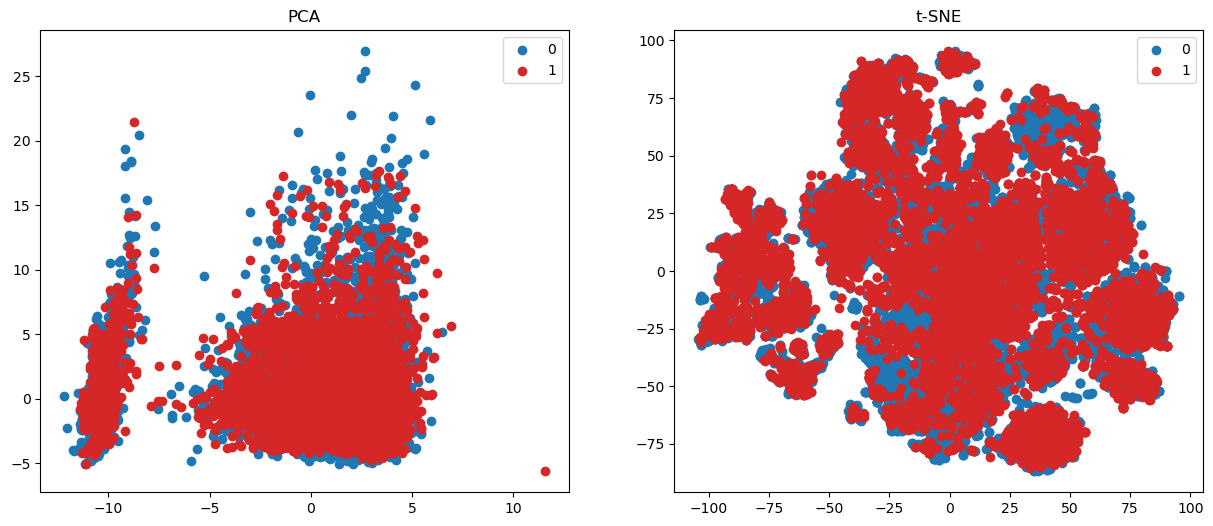

In [12]:
fig,axes = plt.subplots(1,2,figsize=(15,6))
for val,c in zip([0,1],["tab:blue","tab:red"]):
    inds = np.where(y==val)
    axes[0].scatter(X_pca[inds, 0], X_pca[inds, 1], color=c, label=val)
    axes[1].scatter(X_tsne[inds, 0], X_tsne[inds, 1], color=c, label=val)
axes[0].legend()
axes[0].set_title("PCA")
axes[1].legend()
axes[1].set_title("t-SNE")
plt.show()

## Let's try averaging over sessions for each subject

In [13]:
X_ave = np.zeros((groups[-1]+1, X.shape[1]))
y_ave = np.zeros(groups[-1]+1)
for g in np.arange(groups[-1]+1):
    curr_X = X_proc[np.where(groups==g)].mean(axis=0)
    X_ave[g] = curr_X
    y_ave[g] = y[np.where(groups==g)].mean()
print(X_ave.shape)

(442, 96)


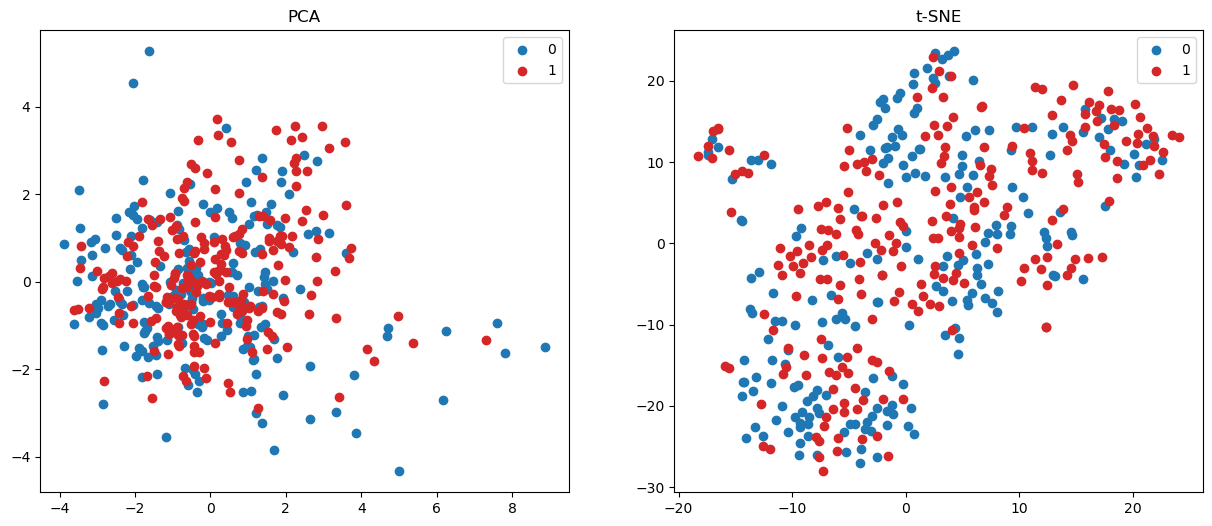

In [14]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_ave)

tsne = TSNE()
X_tsne = tsne.fit_transform(X_ave)

fig,axes = plt.subplots(1,2,figsize=(15,6))
for val,c in zip([0,1],["tab:blue","tab:red"]):
    inds = np.where(y_ave==val)
    axes[0].scatter(X_pca[inds, 0], X_pca[inds, 1], color=c, label=val)
    axes[1].scatter(X_tsne[inds, 0], X_tsne[inds, 1], color=c, label=val)
axes[0].legend()
axes[0].set_title("PCA")
axes[1].legend()
axes[1].set_title("t-SNE")
plt.show()

## Get train/val/test split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_ave, y_ave, test_size=0.15, random_state=42)

## Feature selection

#### Recursive feature selection

In [16]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

min_features_to_select = 5  # Minimum number of features to consider
clf = LogisticRegression()
cv = StratifiedKFold(10)

rfecv = RFECV(
    estimator=clf,
    step=5,
    cv=cv,
    scoring="f1_weighted",
    min_features_to_select=min_features_to_select,
    n_jobs=2,
)
rfecv.fit(X_train, y_train)

print(f"Optimal number of features: {rfecv.n_features_}")

Optimal number of features: 91


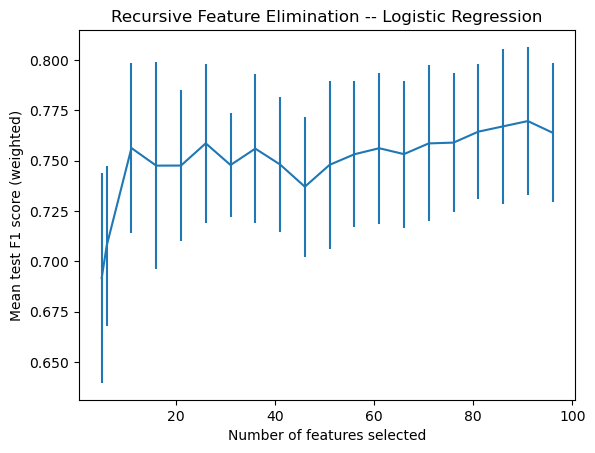

In [17]:
data = {
    key: value
    for key, value in rfecv.cv_results_.items()
    if key in ["n_features", "mean_test_score", "std_test_score"]
}
cv_results = pd.DataFrame(data)
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test F1 score (weighted)")
plt.errorbar(
    x=cv_results["n_features"],
    y=cv_results["mean_test_score"],
    yerr=cv_results["std_test_score"],
)
plt.title("Recursive Feature Elimination -- Logistic Regression")
plt.show()

## Try out some models

In [18]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import clone
import warnings

warnings.filterwarnings('ignore')

print(f"Shapes -> train+val: {X_train.shape}, test: {X_test.shape}")

# 10-fold Stratified CV on the train+val set to produce validation scores
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Models to compare
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Logistic Regression (no reg)': LogisticRegression(penalty=None, solver='saga', max_iter=10000, random_state=42),
    'SVM (linear)': SVC(kernel='linear', random_state=42),
    'SVM (rbf)': SVC(kernel='rbf', random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

# Dictionary to store results per model
cv_results = {}

for name, model in models.items():
    print(f"\nRunning 10-fold CV for: {name}")
    train_f1s = []
    val_f1s = []
    fold = 0

    for train_idx, val_idx in skf.split(X_train, y_train):
        fold += 1
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]

        # Work with a fresh clone of the estimator for each fold
        est = clone(model)
        est.fit(X_tr, y_tr)

        y_tr_pred = est.predict(X_tr)
        y_val_pred = est.predict(X_val)

        tr_f1 = f1_score(y_tr, y_tr_pred, average="weighted")
        val_f1 = f1_score(y_val, y_val_pred, average="weighted")

        train_f1s.append(tr_f1)
        val_f1s.append(val_f1)

        print(f" Fold {fold}: Train F1={tr_f1:.3f}, Val F1={val_f1:.3f}")

    # Summary for this model
    print(f" Summary {name} -> Train F1: {np.mean(train_f1s):.3f} ± {np.std(train_f1s):.3f}; "
          f"Val F1: {np.mean(val_f1s):.3f} ± {np.std(val_f1s):.3f}")

    # Train final estimator on the full train+val set and evaluate on test
    final_est = clone(model)
    final_est.fit(X_train, y_train)
    y_test_pred = final_est.predict(X_test)
    test_f1 = f1_score(y_test, y_test_pred, average="weighted")
    print(f" Test F1 for {name}: {test_f1:.3f}")

    cv_results[name] = {
        'train_f1s': train_f1s,
        'val_f1s': val_f1s,
        'test_f1': test_f1,
        'y_test': y_test,
        'y_test_pred': y_test_pred
    }

Shapes -> train+val: (375, 96), test: (67, 96)

Running 10-fold CV for: Logistic Regression
 Fold 1: Train F1=0.855, Val F1=0.788
 Fold 2: Train F1=0.843, Val F1=0.868
 Fold 3: Train F1=0.852, Val F1=0.710
 Fold 4: Train F1=0.846, Val F1=0.763
 Fold 5: Train F1=0.852, Val F1=0.789
 Fold 6: Train F1=0.846, Val F1=0.756
 Fold 7: Train F1=0.855, Val F1=0.783
 Fold 8: Train F1=0.837, Val F1=0.864
 Fold 9: Train F1=0.840, Val F1=0.594
 Fold 10: Train F1=0.846, Val F1=0.673
 Summary Logistic Regression -> Train F1: 0.847 ± 0.006; Val F1: 0.759 ± 0.079
 Test F1 for Logistic Regression: 0.805

Running 10-fold CV for: Logistic Regression (no reg)
 Fold 1: Train F1=0.929, Val F1=0.815
 Fold 2: Train F1=0.911, Val F1=0.841
 Fold 3: Train F1=0.938, Val F1=0.630
 Fold 4: Train F1=0.935, Val F1=0.707
 Fold 5: Train F1=0.920, Val F1=0.842
 Fold 6: Train F1=0.920, Val F1=0.811
 Fold 7: Train F1=0.923, Val F1=0.729
 Fold 8: Train F1=0.911, Val F1=0.837
 Fold 9: Train F1=0.920, Val F1=0.649
 Fold 10: Tr

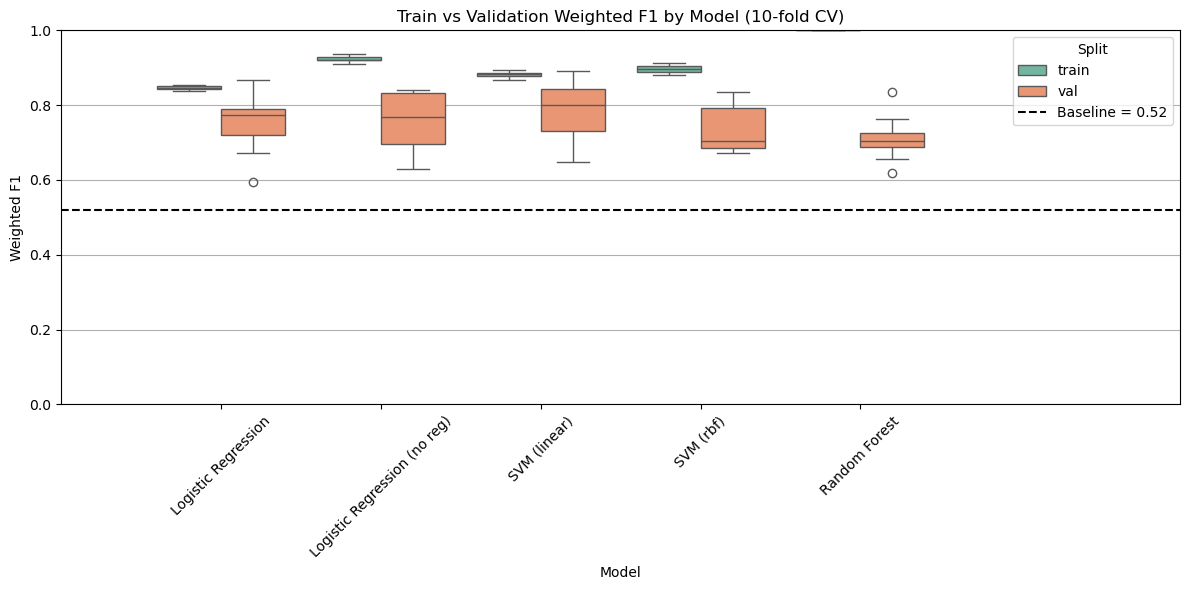


CV summary (mean ± std) and test weighted F1 (10-fold CV):
                       model  train_f1_mean  train_f1_std  val_f1_mean  val_f1_std  test_f1
         Logistic Regression       0.847110      0.005739     0.758764    0.078911 0.804918
Logistic Regression (no reg)       0.923575      0.008527     0.755347    0.078890 0.745927
                SVM (linear)       0.882082      0.008110     0.786173    0.074241 0.835600
                   SVM (rbf)       0.896600      0.010467     0.732090    0.061027 0.804918
               Random Forest       1.000000      0.000000     0.710919    0.055710 0.776419

Final test set performance by model:

Model: Logistic Regression
 Test Weighted F1: 0.805
 Classification report:
              precision    recall  f1-score   support

         0.0       0.82      0.74      0.78        31
         1.0       0.79      0.86      0.83        36

    accuracy                           0.81        67
   macro avg       0.81      0.80      0.80        67
w

In [32]:
# Grouped boxplot: training vs validation F1 per model (10-fold CV)
import seaborn as sns

baseline = y_ave.mean()

model_names = list(cv_results.keys())

# Build long-form DataFrame with one row per fold per model/split
rows = []
for m in model_names:
    for v in cv_results[m]['train_f1s']:
        rows.append({'model': m, 'split': 'train', 'f1': v})
    for v in cv_results[m]['val_f1s']:
        rows.append({'model': m, 'split': 'val', 'f1': v})

plot_df = pd.DataFrame(rows)

plt.figure(figsize=(12, 6))
ax = sns.boxplot(x='model', y='f1', hue='split', data=plot_df, palette='Set2')
ax.hlines([baseline], xmin=-1, xmax=6, ls="--", colors=["k"], label=f"Baseline = {np.round(baseline,2)}")
ax.set_title('Train vs Validation Weighted F1 by Model (10-fold CV)')
ax.set_ylabel('Weighted F1')
ax.set_xlabel('Model')
ax.set_xlim([-1, 6])
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.legend(title='Split')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Summary statistics table (mean ± std) for convenience
summary_rows = []
for m in model_names:
    train_mean = np.mean(cv_results[m]['train_f1s'])
    train_std = np.std(cv_results[m]['train_f1s'])
    val_mean = np.mean(cv_results[m]['val_f1s'])
    val_std = np.std(cv_results[m]['val_f1s'])
    summary_rows.append({'model': m,
                         'train_f1_mean': train_mean,
                         'train_f1_std': train_std,
                         'val_f1_mean': val_mean,
                         'val_f1_std': val_std,
                         'test_f1': cv_results[m]['test_f1']})

summary_df = pd.DataFrame(summary_rows)
print('\nCV summary (mean ± std) and test weighted F1 (10-fold CV):')
print(summary_df[['model','train_f1_mean','train_f1_std','val_f1_mean','val_f1_std','test_f1']].to_string(index=False))

# Print final test F1 and reports per model
from sklearn.metrics import classification_report, confusion_matrix
print('\nFinal test set performance by model:')
for m in model_names:
    print(f"\nModel: {m}")
    print(f" Test Weighted F1: {cv_results[m]['test_f1']:.3f}")
    print(' Classification report:')
    print(classification_report(cv_results[m]['y_test'], cv_results[m]['y_test_pred']))
    print(' Confusion matrix:')
    print(confusion_matrix(cv_results[m]['y_test'], cv_results[m]['y_test_pred']))